In [25]:
# First XGBoost model for Pima Indians dataset
from numpy import loadtxt
from matplotlib import patches
from xgboost import XGBClassifier, plot_tree , plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from tqdm import tqdm
# load data

if __name__ == '__main__':
    listdir = os.listdir('npiy')
    first = True
    for datapath in tqdm(listdir):
        if first:
            dataset = np.load('npiy/'+datapath)
            first = False
        else:
            data = np.load('npiy/'+datapath)
            dataset = np.concatenate([dataset,data],axis = 0)

    

100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


In [27]:
X = dataset[:,:40]
Y = dataset[:,40]

In [3]:
features = ['ball_pos_x','ball_pos_y','ball_pos_z','prev_pos_x','prev_pos_y','prev_pos_z',
                'next_pos_x','next_pos_y','next_pos_z','prev_speed_x','prev_speed_y','prev_speed_z',
                'next_speed_x','next_speed_y','next_speed_z',
            'mean_homex','mean_homey','mean_homespeed','front_home','back_home','left_home','right_home',
            'len(home_players)','la_ratio','ra_ratio','ma_ratio',
            'mean_awayx','mean_awayy','mean_awayspeed','front_away','back_away','left_away','right_away',
            'len(away_players)','lh_ratio','rh_ratio','mh_ratio',
                'refx','refy','refspeed'
            ,'output']



In [4]:
def CreatePitch(viz):
    """Function that draws a pitch with dimensions 105x68"""

    #Create figure
    fig=plt.figure(0,figsize=(6.4*2,4.8*2))
    ax=fig.add_subplot(1,1,1)
    pl = 105.0
    pw = 68.0
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,68], color="black")
    plt.plot([0,105],[68,68], color="black")
    plt.plot([105,105],[68,0], color="black")
    plt.plot([105,0],[0,0], color="black")
    plt.plot([52.5,52.5],[0,68], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[13.84,54.16],color="black")
    plt.plot([0,16.5],[54.16,54.16],color="black")
    plt.plot([16.5,0],[13.84,13.84],color="black")

    #Left goal
    plt.plot([-2,-2],[30.34,37.66],color="black")
    plt.plot([-2,0],[30.34,30.34],color="black")
    plt.plot([0,-2],[37.66,37.66],color="black")

    #Right goal
    plt.plot([107,107],[30.34,37.66],color="black")
    plt.plot([107,105],[30.34,30.34],color="black")
    plt.plot([105,107],[37.66,37.66],color="black")

    #Right Penalty Area
    plt.plot([105,88.5],[54.16,54.16],color="black")
    plt.plot([88.5,88.5],[54.16,13.84],color="black")
    plt.plot([88.5,105],[13.84,13.84],color="black")

    #Left Small Area
    plt.plot([0,5.5],[43.16,43.16],color="black")
    plt.plot([5.5,5.5],[43.16,24.84],color="black")
    plt.plot([5.5,0],[24.84,24.84],color="black")

    #Right Small Area
    plt.plot([105,99.5],[43.16,43.16],color="black")
    plt.plot([99.5,99.5],[43.16,24.84],color="black")
    plt.plot([99.5,105],[24.84,24.84],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((52.5,34),9.15,color="black",fill=False)
    centreSpot = plt.Circle((52.5,34),0.4,color="black",fill=False)
    leftPenSpot = plt.Circle((11,34),0.4,color="black",fill=False)
    rightPenSpot = plt.Circle((94,34),0.4,color="black",fill=False)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs  #Matplotlib missing
    leftArc = patches.Arc((11,34),height=16.4,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = patches.Arc((94,34),height=16.4,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)


    if viz['mean_homex']!=-1:
        plt.scatter(viz['mean_homex']*pl,viz['mean_homey']*pw,s=100,c='r',edgecolors='k',zorder=2,label = 'home_team')
        c1,c2 = min(viz['front_away'], viz['back_away'])*pl ,min(viz['left_away'], viz['right_away'])*pw
        w,h = max(viz['front_away'], viz['back_away'])*pl ,max(viz['left_away'], viz['right_away'])*pw
        rect1 = patches.Rectangle((c1,c2), w-c1, h-c2, linewidth=1, edgecolor='g',facecolor ='None')
        ax.add_patch(rect1)
        
    if viz['mean_awayx']!=-1:
        plt.scatter(viz['mean_awayx']*pl,viz['mean_awayy']*pw,s=100,c='g',edgecolors='k',zorder=2,label = 'away_team')
        c1,c2 = min(viz['front_home'], viz['back_home'])*pl ,min(viz['left_home'], viz['right_home'])*pw
        w,h = max(viz['front_home'], viz['back_home'])*pl ,max(viz['left_home'], viz['right_home'])*pw
        rect2 = patches.Rectangle((c1,c2), w-c1, h-c2, linewidth=1, edgecolor='r',facecolor ='None')
        ax.add_patch(rect2)

    if viz['refx']!=-1:
        plt.scatter(viz['refx']*pl,viz['refy']*pw,s=100,c='y',edgecolors='k',zorder=2,label = 'referee')
        
    scale = 1000 # for making the ball velocity vector visible
    if viz['prev_pos_x']!=-1:
        plt.scatter(viz['prev_pos_x']*pl,viz['prev_pos_y']*pw,s=100,c='black',edgecolors='k',zorder=2,label = 'ball_prev_loc')
        ax.annotate("", xytext=(viz['prev_pos_x']*pl, viz['prev_pos_y']*pw), 
                    xy=((viz['prev_speed_x']*pl*scale)+ viz['prev_pos_x']*pl, (viz['prev_speed_y']*pw*scale)+viz['prev_pos_y']*pw),  arrowprops=dict(arrowstyle="->"))
        
    if viz['next_pos_x']!=-1:
        plt.scatter(viz['next_pos_x']*pl,viz['next_pos_y']*pw,s=100,c='gray',edgecolors='k',zorder=2,label = 'ball_next_loc')
        ax.annotate("", xytext=(viz['next_pos_x']*pl, viz['next_pos_y']*pw), 
                    xy=(viz['next_pos_x']*pl + (viz['next_speed_x']*pl*scale), viz['next_pos_y']*pw + (viz['next_speed_y']*pw*scale)),
                    arrowprops=dict(arrowstyle="->"))
        
    if viz['ball_pos_x']!=-1:
        plt.scatter(viz['ball_pos_x']*pl,viz['ball_pos_y']*pw,s=100,c='white',edgecolors='k',zorder=2,label = 'ball_current_loc')
        
    rect3 = patches.Rectangle((0,0), 16.5, 68, linewidth=1, edgecolor='none',facecolor ='blue',zorder = 0)
    ax.add_patch(rect3)

    rect4 = patches.Rectangle((88.5,0), 16.5, 68, linewidth=1, edgecolor='none',facecolor ='orange',zorder = 0)
    ax.add_patch(rect4)
    
    
    #Tidy Axes
    plt.gca().invert_yaxis()
    leg = plt.legend()
    return


In [5]:
# features

viz = dict(zip(features,X[Y==1][1])) # Y==1 indicates home corner

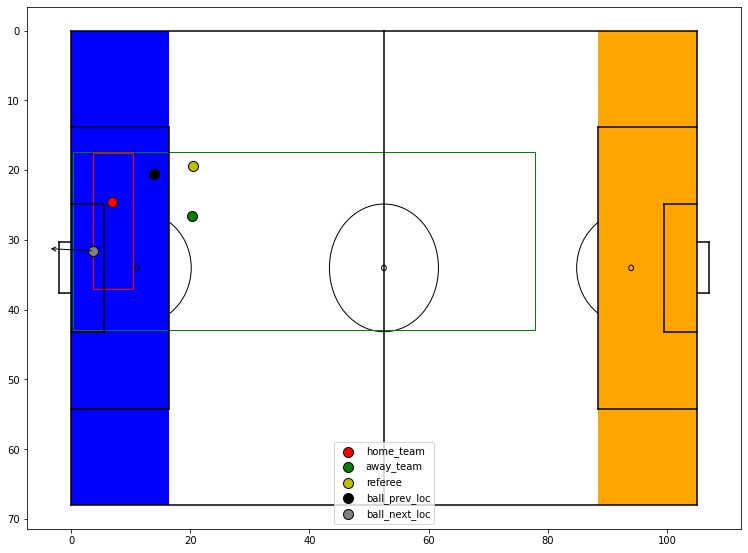

In [6]:
CreatePitch(viz)

# fig = plt.figure()
# blue region - left third
# white region - middle third
# orange region - right third

In [112]:
viz

{'mean_homex': -1.0,
 'mean_homey': -1.0,
 'mean_homespeed': -1.0,
 'front_home': -1.0,
 'back_home': -1.0,
 'left_home': -1.0,
 'right_home': 0.79695237,
 'len(home_players)': 0.47819048,
 'la_ratio': 0.0,
 'ra_ratio': -1.0,
 'ma_ratio': -1.0,
 'mean_awayx': -1.0,
 'mean_awayy': -0.00026666667,
 'mean_awayspeed': 0.00038095238,
 'front_away': 0.0,
 'back_away': 0.612658,
 'left_away': 0.3370476,
 'right_away': 3.5376363,
 'len(away_players)': 0.8893333,
 'lh_ratio': 0.354,
 'rh_ratio': 0.48685715,
 'mh_ratiorefx': 0.18685715,
 'refy': 11.0,
 'refspeed': 0.0,
 'ball_pos_x': 0.09090909,
 'ball_pos_y': 0.90909094,
 'ball_pos_z': 0.4943117,
 'prev_pos_x': 0.3642857,
 'prev_pos_y': 3.910818,
 'prev_pos_z': 0.674,
 'next_pos_x': 0.09438095,
 'next_pos_y': 0.5456191,
 'next_pos_z': 0.16447619,
 'prev_speed_x': 11.0,
 'prev_speed_y': 0.09090909,
 'prev_speed_z': 0.0,
 'next_speed_x': 0.90909094,
 'next_speed_y': 0.5563809,
 'next_speed_z': 0.23180953}

/home/pavithran/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[18:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:16:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[18:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 

[18:20:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:20:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:20:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:20:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned

[18:24:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:24:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:24:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[18:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[18:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:24:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[18:28:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:28:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[18:28:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[18:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:28:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[18:32:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:32:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[18:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:32:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[18:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[18:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned no

[18:36:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:36:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[18:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[18:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[18:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[18:40:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:40:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

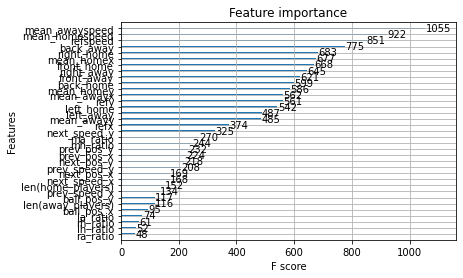

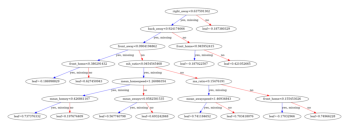

Accuracy: 91.25%


In [28]:
    seed = 5
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    # fit model no training data
    model = XGBClassifier()
    setattr(model, 'verbosity', 2)
    model.fit(X_train, y_train,verbose=True)
    print("Done")
    features = ['mean_homex', 'mean_homey', 'mean_homespeed', 'front_home', 'back_home', 'left_home', 'right_home',
                'len(home_players)', 'la_ratio', 'ra_ratio', 'ma_ratio',
                'mean_awayx', 'mean_awayy', 'mean_awayspeed', 'front_away', 'back_away', 'left_away', 'right_away',
                'len(away_players)', 'lh_ratio', 'rh_ratio', 'mh_ratio'
                                                             'refx', 'refy', 'refspeed', 'ball_pos_x', 'ball_pos_y',
                'ball_pos_z', 'prev_pos_x', 'prev_pos_y', 'prev_pos_z',
                'next_pos_x', 'next_pos_y', 'next_pos_z', 'prev_speed_x', 'prev_speed_y', 'prev_speed_z',
                'next_speed_x', 'next_speed_y', 'next_speed_z']
    plot_importance(model, fmap='xgb.fmap')
    plot_tree(model, fmap='xgb.fmap')
    plt.show()
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    predictions = np.array(predictions)
    # testing accuracy when there is a corner kick
    accuracy = accuracy_score(y_test[np.where(y_test != 0)], predictions[np.where(y_test != 0)])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # print(confusion_matrix(y_test, y_pred))


Text(0.5, 1.0, 'confusion matrix')

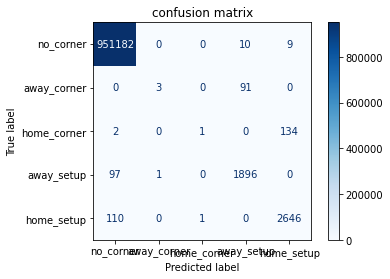

In [29]:
from sklearn.metrics import plot_confusion_matrix, f1_score
disp = plot_confusion_matrix(model, X_test,y_test,
                             display_labels=['no_corner','away_corner','home_corner','away_setup','home_setup'],
                             cmap=plt.cm.Blues,)
disp.ax_.set_title('confusion matrix')

In [30]:
f1_score(y_test,predictions,average=None)

array([0.99988016, 0.06122449, 0.01438849, 0.95013781, 0.95420123])

In [31]:
accuracy_score(y_test, predictions)

0.9995241496659112

In [32]:
len(dataset)

2897522